# Projet Inpainting

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from random import shuffle

import tools
import importlib
import matplotlib.patches as patches
importlib.reload(tools)

from tools import filter_classes, read_img

from matplotlib import gridspec
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb


from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import warnings
warnings.filterwarnings("ignore")

Le but de ce projet, Inpainting sur des images avec LASSO, est de pouvoir supprimer du bruit d'une image (pixels morts que l'on doit spécifier) ou mieux encore, supprimer certaines parties de l'image. La reconstruction se fait à l'aide de l'algorithme LASSO appris sur un dictionnaire constitué à partir de patchs non bruité de cette même image.

# Préamblue
## Regression Linéaire, RIDGE, LASSO

In [2]:
x_train, y_train = tools.load_usps("USPS/USPS_train.txt")
x_test,  y_test  = tools.load_usps("USPS/USPS_test.txt")

x_train_mean = x_train.mean()
x_train_std  = x_train.std()

#normalize data
x_train = (x_train - x_train_mean) / x_train_std
x_test  = (x_test  - x_train_mean) / x_train_std

In [3]:
class LinearClassifier:
    def __init__(self, penalty=None, alpha=1., use_tqdm=True):
        """Cette classe permet de pouvoir choisir plus facilement si l'on souhaite utiliser
        un classifieur linéaire, RIDGE ou LASSO ainsi que de les paramêtrer facilement.
        
        :param penalty: None pour reg. lin. sans regularisation, 'l1' pour LASSO, 'l2' pour RIDGE
        :param alpha: cf. param alpha des classes LASSO & RIDGE de sklearn
        :param use_tqdm: affiche ou non une barre de progression
        
        :type penalty: str / None
        :type alpha: float
        :type use_tqdm: bool
        
        :return: instance de la classe
        :rtype: LinearClassifier
        """
        self.penalty = penalty
        self.alpha = alpha
        self.use_tqdm = use_tqdm
        self.clf_class = LinearRegression if not penalty else (Ridge if penalty == 'l2' else Lasso)
    
    def fit(self, x_train, y_train):
        """Entraine le classifieur.
        
        :param x_train: liste des exemples
        :param y_train: liste des labels associés
        
        :type x_train: np.array (2D)
        :type y_train: np.array
        """
        #prepare one classifier by class
        self.clfs_names = sorted(set(y_train))
        self.clfs = {
            name: self.clf_class(
                **{'alpha': self.alpha}
                if not self.clf_class == LinearRegression 
                else {}) 
            for name in self.clfs_names
        }
        #prepare the datasets for each classifier (1vsAll) and fit each classifier
        for class_to_separe in (tqdm(self.clfs_names) if self.use_tqdm else self.clfs_names):
            #select the classes
            all_classes = self.clfs_names[:]
            all_other_classes = all_classes[:]
            all_other_classes.remove(class_to_separe)
            #split the data to train
            x, y = filter_classes(x_train, y_train, [class_to_separe], all_other_classes)
            y = np.array(y) * 2 - 1 #class -1, +1
            data_x_y = list(zip(x, y))
            shuffle(data_x_y)
            x, y = zip(*data_x_y)
            x, y = np.array(x), np.array(y)
            #fit the classifier
            self.clfs[class_to_separe].fit(x, y)
            
    def plot_coefs(self, shape):
        """Affiche les coefficient sous forme d'une image.
        <!> les coefficients doivent être au nombre de shape[0] * shape[1] !
        
        :param shape: taille du rectangle de l'image a afficher
        
        :type shape: tuple
        """
        fig = plt.figure(figsize=(15, 15))
        gs = gridspec.GridSpec(4 + 1, len(self.clfs_names) // 4 + 2) #4 img by row
        
        for i, c in enumerate(self.clfs_names):
            ax = fig.add_subplot(gs[i // 4, i % 4])
            ax.axis('off')
            ax.set_title(str(c), color='red')
            ax.imshow(self.clfs[c].coef_.reshape(shape), cmap='gray')
        gs.update(wspace=.1, hspace=.2)
        fig = plt.gcf()
        fig.show()
        
    
    def predict(self, x_test):
        """Predit la classe des donnees de x_test.
        
        :param x_test: donnees a classifier
        
        :type x_test: np.array (2D)
        
        :return: liste des labels predits associes a chaque element de x_test
        :rtype:
        """
        #return the first number predicted as true
        return np.array([
            self.clfs_names[cc] 
            for cc in \
            (np.array([self.clfs[c].predict(x_test) for c in self.clfs_names]) > 0).argmax(0)
        ])
    
    def score(self, x_test, y_test):
        """Permet d'evaluer le classifieur a l'aide de la metrique f1.
        
        :param x_test: exemples a predire
        :param y_test: labels des exemples a predire
        
        :return: le score du classifier
        :rtype: float
        """
        return f1_score(y_test, self.predict(x_test), average=None).mean()

In [4]:
def get_clf_score(penalty, alpha, x_train, y_train, x_test, y_test, nb_runs=100):
    scores = []
    for _ in range(nb_runs):
        clf = LinearClassifier(penalty=penalty, alpha=alpha, use_tqdm=False)
        clf.fit(x_train, y_train)
        scores.append(clf.score(x_test, y_test))
    return np.array(scores).mean()


In [5]:
no_reg_score = get_clf_score(None,  0., x_train, y_train, x_test, y_test)
reg_l1_score = get_clf_score('l1', .05, x_train, y_train, x_test, y_test)
reg_l2_score = get_clf_score('l2',  1., x_train, y_train, x_test, y_test)

print("no reg :", no_reg_score)
print("l1 reg :", reg_l1_score)
print("l2 reg :", reg_l2_score)

no reg : 0.7558047962935329
l1 reg : 0.7144979032823079
l2 reg : 0.7581624310249394


Les scores des classifieurs avec régularisation varient en fonction de l'importance de cette dernière (paramètre alpha).

### Affichage des Poids
#### Sans Regularisation

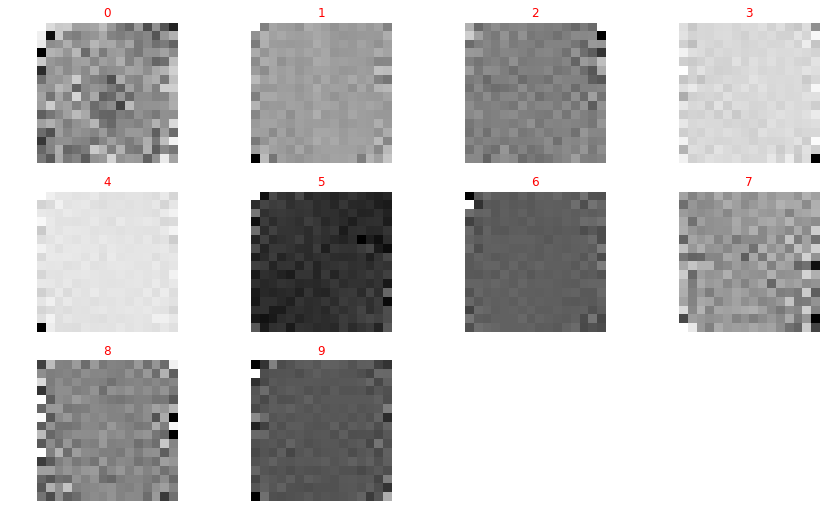

In [6]:
clf = LinearClassifier(penalty=None, use_tqdm=False)
clf.fit(x_train, y_train)
clf.plot_coefs((16, 16))

Avec regression sans regularisation, les poids ne sont pas revelateurs. En effet, il se base sur les pixels situés sur les bords

In [39]:
# Regularisation avec L2

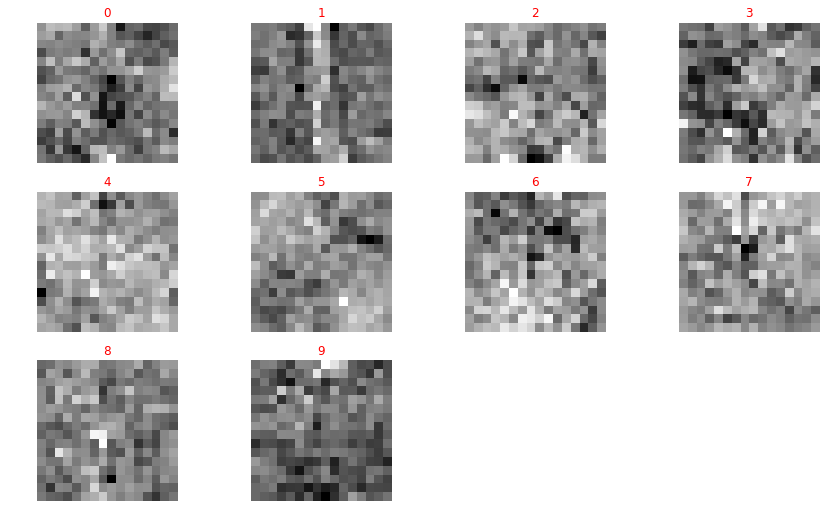

In [8]:
clf = LinearClassifier(penalty='l2', alpha=100, use_tqdm=False)
clf.fit(x_train, y_train)
clf.plot_coefs((16, 16))

Avec une regularisation L2, les poids sont plus representatifs que les poids precedent.
En effet, on arrive a voir les pixels participant a la reresentation d'un chiffre.
Pour le chiffre 1 ces pixels sont concentrés sur une barre verticale au centre de l'image.


#### Regularisation L1

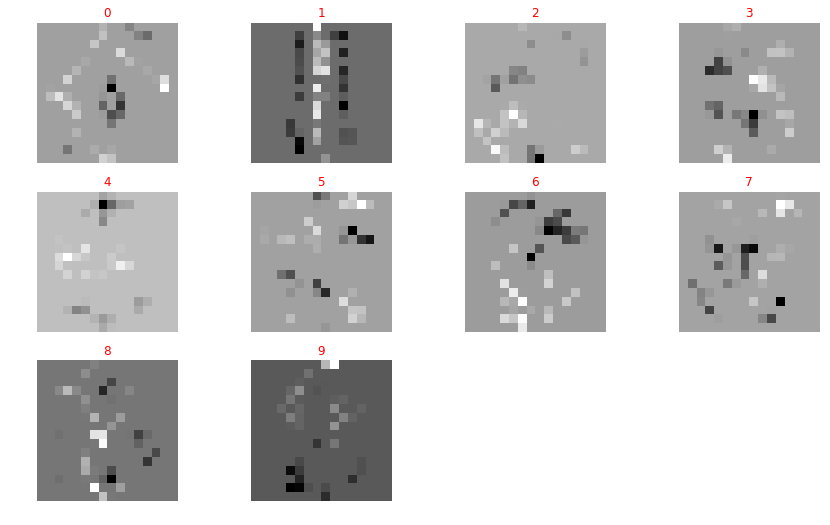

In [9]:
clf = LinearClassifier(penalty='l1', alpha=.05, use_tqdm=False)
clf.fit(x_train, y_train)
clf.plot_coefs((16, 16))

Avec une regularisation L1, la plupart des poids sont a nul et les quelques poids selectionnés suffisent a obtenir des scores similaires aux precedents.


# LASSO et Inpainting 

In [10]:
H = 20
DEAD = -100
importlib.reload(tools)

IMG_FILE = "imgs/rayures.jpg"


In [11]:
plt.ion()
img = tools.read_img(IMG_FILE)
patch = tools.get_patch(100, 100, img)
noisy = tools.noise_patch(patch)
imgnew, oldpatch = tools.remove_patch(100, 100, img)

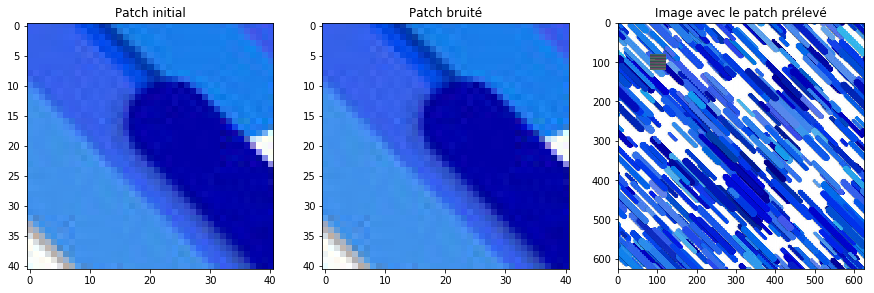

In [36]:
fig = plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title("Patch initial")
plt.imshow(hsv_to_rgb(patch + .5))
plt.subplot(132)
plt.title("Patch bruité")
plt.imshow(hsv_to_rgb(noisy+ .5))
plt.subplot(133)
plt.title("Image avec le patch prélevé")
plt.imshow(hsv_to_rgb(imgnew+ .5))
plt.show()

Nombre de patch valides : 6883 ; nombre de patch bruité : 360353


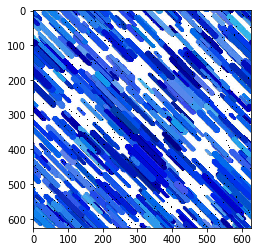

In [38]:
noisy_img = tools.noise_patch(img, prc=.01)
tools.show(noisy_img)
dict_patches, noisy_patches = tools.get_patches(noisy_img, H, 1)
print("Nombre de patch valides :", len(dict_patches), "; nombre de patch bruité :", len(noisy_patches))

## Inpainting Noise

In [14]:
class PatchesSelector:
    def __init__(self, alpha=.1):
        """Classe PatchesSelector permet de decomposer
        un patch en une combinaison restreintes en nombre
        de patch en foncton d'un dictionnaire visuel de patch.
          Le parametre alpha permet d'influencer le nombre
        de patchs a selectionner par LASSO.
        
        :param alpha: cf. alpha 
        """
        self.alpha = alpha
        
    def fit(self, patches_dict, noisy_patch):
        self.noisy_patch = noisy_patch
        #"""#build one regressor by channel...
        self.regressor_h = Lasso(alpha=self.alpha)
        self.regressor_s = Lasso(alpha=self.alpha)
        self.regressor_v = Lasso(alpha=self.alpha)
        #prepare data
        (x_h, x_s, x_v), (y_h, y_s, y_v) = ([], [], []), ([], [], [])
        for i in range(patches_dict[0].shape[0]):
            for j in range(patches_dict[0].shape[1]):
                if not DEAD in noisy_patch[i, j]:
                    x_h.append(np.array(patches_dict)[:, i, j, 0].flatten())
                    x_s.append(np.array(patches_dict)[:, i, j, 1].flatten())
                    x_v.append(np.array(patches_dict)[:, i, j, 2].flatten())
                    y_h.append(noisy_patch[i, j, 0])
                    y_s.append(noisy_patch[i, j, 1])
                    y_v.append(noisy_patch[i, j, 2])
        #fit the regressors
        self.regressor_h.fit(x_h, y_h)
        self.regressor_s.fit(x_s, y_s)
        self.regressor_v.fit(x_v, y_v)
        """
        patches_dict = np.array([p.flatten() for p in patches_dict]).T
        noisy_patch  = np.array(noisy_patch).flatten()
        self.regressor = Lasso(alpha=self.alpha)
        self.regressor.fit(patches_dict, noisy_patch)"""
        
    
    def reconstruct(self, patches_dict, noisy_patch=None):
        noisy_patch = self.noisy_patch if str(noisy_patch) == str(None) else noisy_patch
        noisy_patch = noisy_patch.copy()
        #try to reconstruct the image
        for i in range(noisy_patch.shape[0]):
            for j in range(noisy_patch.shape[1]):
                if DEAD in noisy_patch[i, j]:
                    h = self.regressor_h.predict([np.array(patches_dict)[:, i, j, 0]])[0]
                    s = self.regressor_s.predict([np.array(patches_dict)[:, i, j, 1]])[0]
                    v = self.regressor_v.predict([np.array(patches_dict)[:, i, j, 2]])[0]
                    noisy_patch[i, j, :] = np.array([h, s, v])
        return noisy_patch

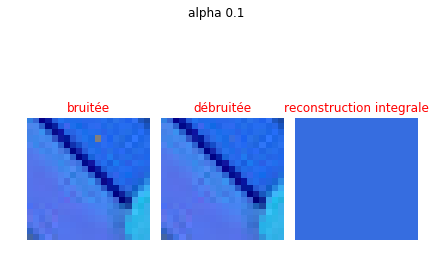

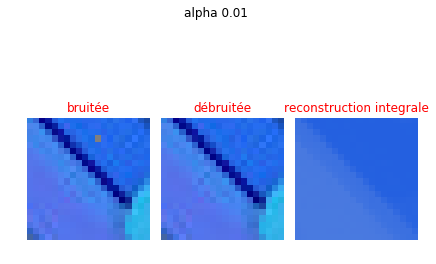

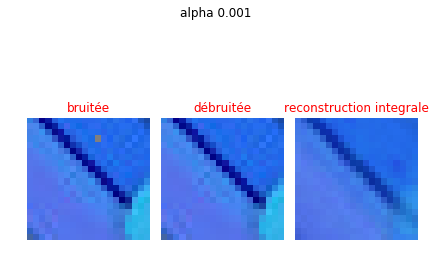

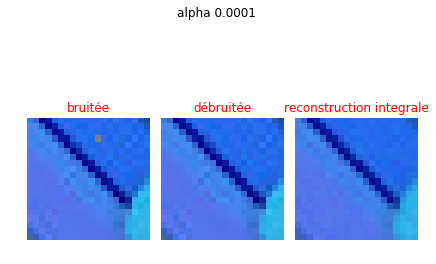

In [15]:
alphas = [.0001, .001, .01, 0.1][::-1]

import warnings
warnings.filterwarnings("ignore")

for alpha in alphas:
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(1, 3) # img by row
    fig.suptitle("alpha {}".format(str(alpha)))
    
    ax = fig.add_subplot(gs[0, 0])
    ax.axis('off')
    ax.set_title("bruitée", color='red')
    ax.imshow(hsv_to_rgb(noisy_patches[1715] + .5))


    ps = PatchesSelector(alpha=alpha)
    ps.fit(dict_patches, noisy_patches[1715])
    ax = fig.add_subplot(gs[0, 1])
    ax.axis('off')
    ax.set_title("débruitée", color='red')
    ax.imshow(hsv_to_rgb(ps.reconstruct(dict_patches) + .5))

    rec = ps.reconstruct(dict_patches, noisy_patch=np.ones((H, H, 3)) * DEAD)
    ax = fig.add_subplot(gs[0, 2])
    ax.axis('off')
    ax.set_title("reconstruction integrale", color='red')
    ax.imshow(hsv_to_rgb(rec + .5))
    
    gs.update(wspace=.1, hspace=.2)
    fig = plt.gcf()
    
    fig.show()

## Inpainting Patches

### Heuristics Ideas
-----------------------

In [16]:
def get_nbgs(i, j):
    out = []
    for ii in range(i - 1, i + 2):
        for jj in range(j - 1, j + 2):
            if (ii, jj) != (i, j):
                out.append((ii, jj))
    return out

def order_by_corner(L):
    L = L[:]
    ordered_list = []
    while L:
        ngbs = np.array(list(map(
                lambda c: len(list(filter(lambda c: c in L, get_nbgs(c[0], c[1])))),
                L
        )))
        t = []
        for i in np.where(ngbs == min(ngbs))[0]:
            ordered_list.append(L[i])
            t.append(L[i])
        for c in t:
            L.remove(c)
    return ordered_list

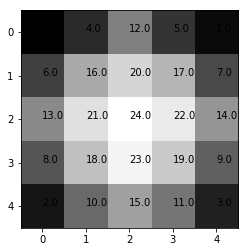

In [17]:
L = [(i, j) for i in range(5) for j in range(5)]

M = np.zeros((5, 5))
ordered_list = order_by_corner(L)
for i in range(len(ordered_list)):
    M[ordered_list[i]] = i
M, ordered_list

tools.affichageHeuristique(M)

## Excution des heuristiques

### Naive Way

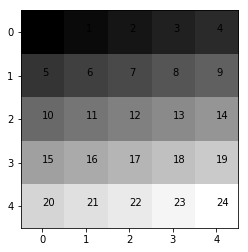

In [18]:
importlib.reload(tools)
tools.affichageHeuristique(np.arange(25).reshape(5,-1))

L'approche Naive reconstruit le noisy patch dans le sens de la lecture.
Lors de la reconstruction l'erreur se voit propagé, les pixels deviennent dependants des valeurs inferées auparavant.
Marche bien sur des images rayer a 90 degré.

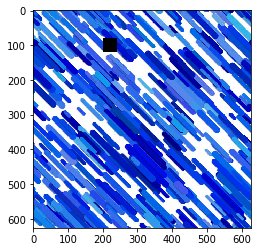

In [19]:
dropped_img = tools.remove_patch(
    100, 220,
    img, 20
)[0]
tools.show(dropped_img)

In [21]:
reconstructed_img = dropped_img.copy()

dico, c = tools.get_patches(dropped_img, H, 5)
dico = dico[:100] #limit the number of patches allowed for learning to improve speed !!!
for i in range(len(reconstructed_img) - H):
    for j in range(len(reconstructed_img[0]) - H):
        if not reconstructed_img[i+H, j+H, 0] == DEAD:
            continue
        lasso = PatchesSelector(alpha=0.001)
        lasso.fit(dico, reconstructed_img[i:i+H, j:j+H, :])
        reconstructed_img[i+H, j+H] = lasso.reconstruct(dico)[-1, -1]

In [22]:
IMG_FILE = "imgs/ile.jpg"

class ReconstructionNaive:
    def reconstruct(self, img, alpha=.001, patch_size=20, limit_dico_size=100):
        reconstructed_img = img.copy()
        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:limit_dico_size] #limit the number of patches allowed for learning to improve speed !!!
        for i in trange(len(reconstructed_img) - patch_size):
            for j in range(len(reconstructed_img[0]) - patch_size):
                if not reconstructed_img[i+patch_size, j+patch_size, 0] == DEAD:
                    continue
                lasso = PatchesSelector(alpha=alpha)
                lasso.fit(dico, reconstructed_img[i:i+patch_size, j:j+patch_size, :])
                reconstructed_img[i+patch_size, j+patch_size] = lasso.reconstruct(dico)[-1, -1]
        return reconstructed_img

In [23]:
def reconstruction(img, method=ReconstructionNaive, patch_size=20, alpha=0.01):
    return method().reconstruct(img, alpha=alpha, patch_size=patch_size)

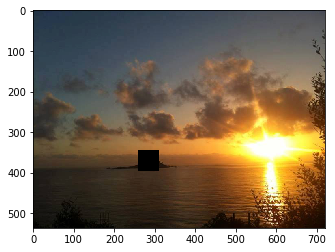

In [24]:
img = tools.read_img(IMG_FILE)
dropped_img = tools.remove_patch(370, 285, img, 25)[0]
tools.show(dropped_img)

100%|██████████| 517/517 [05:59<00:00,  1.44it/s]


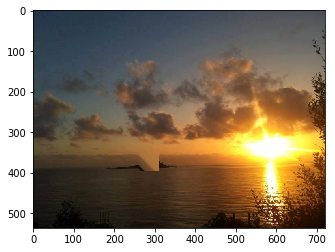

In [27]:
reconstructed_img = reconstruction(dropped_img, ReconstructionNaive)
tools.show(reconstructed_img)

100%|██████████| 606/606 [05:40<00:00,  1.78it/s]


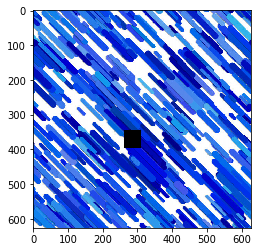

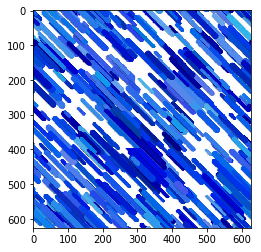

In [28]:
IMG_FILE = "imgs/rayures.jpg"

img = tools.read_img(IMG_FILE)
dropped_img = tools.remove_patch(370, 285, img, 25)[0]
tools.show(dropped_img)
reconstructed_img = reconstruction(dropped_img, ReconstructionNaive)
tools.show(reconstructed_img)

### Reconstruction corner

L'approche Corner reconstruit l'image en commençant par remplir les points les plus extremes.
Nous obtenons des resultats plus interessants car en reposant non plus seulement sur le seul coin haut gauche du patch à reconstruire, nous utilisons les 4 coins pour la compléter en partant des 4 bords. Cette méthode permet de mieux prendre en compte le _contexte_ de l'image (les 4 coins vont permettre 


In [29]:
class ReconstructionCorner:
    def reconstruct(self, dropped_img, alpha=.001, patch_size=20, limit_dico_size=100):
        X, Y = np.where(dropped_img[:, :, 0] == DEAD)
        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:1500]
        reconstructed_img = dropped_img.copy()
        coords_to_fill = list(zip(X, Y))
        coords_to_fill = order_by_corner(coords_to_fill)

        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:limit_dico_size]
        reconstructed_img = dropped_img.copy()
        
        for nb_pixel_reconstructed, (x, y) in tqdm(list(enumerate(coords_to_fill))):
            xx, yy = x, y
            if tools.hautDroite(reconstructed_img, x, y):
                x, y = x - patch_size, y - patch_size
                indx , indy = -1, 0
            elif tools.hautGauche(reconstructed_img, x, y):
                x, y = x - patch_size, y + patch_size
                indx , indy = -1, -1
            elif tools.basDroite(reconstructed_img, x, y):
                x, y = x + patch_size, y + patch_size
                indx , indy = 0, -1
            elif tools.basGauche(reconstructed_img, x, y):
                x, y = x + patch_size, y - patch_size
                indx, indy = 0, 0

            lasso = PatchesSelector(alpha=0.01)
            lasso.fit(dico, reconstructed_img[x:x+patch_size, y:y+patch_size])
            rp = lasso.reconstruct(dico, reconstructed_img[x:x+patch_size, y:y+patch_size])
            reconstructed_img[xx, yy] = rp[indx, indy]
        
        return reconstructed_img

100%|██████████| 2601/2601 [05:54<00:00,  7.34it/s]


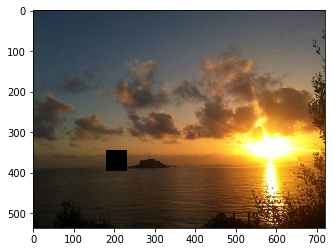

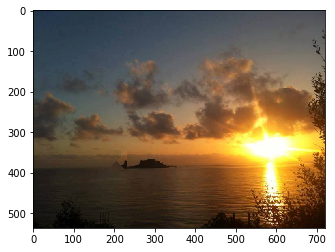

In [30]:
IMG_FILE = "imgs/ile.jpg"

img = tools.read_img(IMG_FILE)
dropped_img = tools.remove_patch(370, 205, img, 25)[0]
tools.show(dropped_img)
reconstructed_img = reconstruction(dropped_img, ReconstructionCorner)
tools.show(reconstructed_img)

100%|██████████| 2601/2601 [06:14<00:00,  6.94it/s]


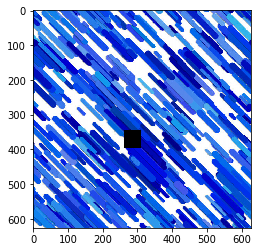

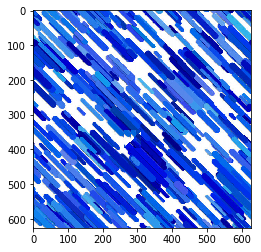

In [32]:
IMG_FILE = "imgs/rayures.jpg"

img = tools.read_img(IMG_FILE)
dropped_img = tools.remove_patch(370, 285, img, 25)[0]
tools.show(dropped_img)
reconstructed_img = reconstruction(dropped_img, ReconstructionCorner)
tools.show(reconstructed_img)

### Reconstruction spirale

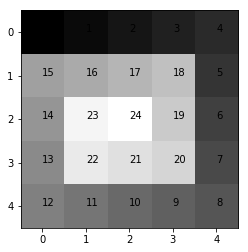

In [33]:
tools.affichageHeuristique(tools.spiral(5, 5))

L'approche spirale est un mélange des deux précédentes approches. On cherche à remplir l'image en prenant son contexte en compte de tout les côtés. Cependant cette fois l'ordre est important et selon l'orientation de la spirale, celle-ci ne rendra pas le même résultat

In [34]:
class ReconstructionSpiral:
    
    def reconstruct(self, dropped_img, alpha=.001, patch_size=20, limit_dico_size=100):
        
        X, Y = np.where(dropped_img[:, :, 0] == DEAD)
        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:1500]
        reconstructed_img = dropped_img.copy()
        coords_to_fill = np.array(tools.spiral(
            len(dropped_img) - patch_size, 
            len(dropped_img[0]) - patch_size
        ))
        #print(coords_to_fill)
        mat = []
        
        for i in range(len(coords_to_fill)):
            row = [] 
            for j in range(len(coords_to_fill[0])):
                row.append([i,j])
            mat.append(row)
        mat =  np.array(mat)
            
        coords = list( zip(coords_to_fill.flatten(),mat[:, :, 0].flatten(), mat[:, :, 1].flatten()))
        coords = sorted(coords)
        coords_to_fill = list(map(lambda c: (c[1],c[2]),  coords))
        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:limit_dico_size]
        reconstructed_img = dropped_img.copy()
        
        for nb_pixel_reconstructed, (x, y) in tqdm(list(enumerate(coords_to_fill))):
            xx, yy = x, y
            if DEAD in reconstructed_img[x:x + patch_size, y:y + patch_size] :
                if tools.hautDroite(reconstructed_img, x, y):
                    x, y = x - patch_size, y - patch_size,
                    indx , indy = -1, 0
                elif tools.hautGauche(reconstructed_img, x, y):
                    x, y = x - patch_size, y + patch_size,
                    indx , indy = -1, -1
                elif tools.basDroite(reconstructed_img, x, y):
                    x, y = x + patch_size, y + patch_size,
                    indx , indy = 0, -1
                elif tools.basGauche(reconstructed_img, x, y):
                    x, y = x + patch_size, y - patch_size,
                    indx, indy = 0, 0

                lasso = PatchesSelector(alpha=0.01)
                lasso.fit(dico, reconstructed_img[x:x + patch_size, y:y + patch_size])
                rp = lasso.reconstruct(dico, reconstructed_img[x:x + patch_size, y:y + patch_size])
                reconstructed_img[xx, yy] = rp[indx, indy]
        
        return reconstructed_img



100%|██████████| 361900/361900 [10:25<00:00, 578.35it/s]   


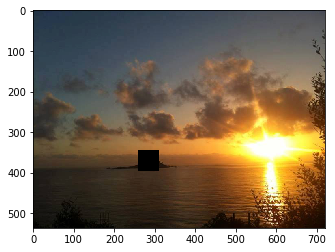

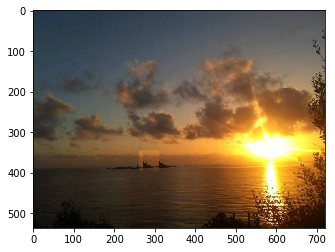

In [35]:
IMG_FILE = "imgs/ile.jpg"

img = tools.read_img(IMG_FILE)
dropped_img = tools.remove_patch(370, 285, img, 25)[0]
tools.show(dropped_img)
reconstructed_img = reconstruction(dropped_img, ReconstructionSpiral)
tools.show(reconstructed_img)

100%|██████████| 367236/367236 [07:22<00:00, 829.38it/s]   


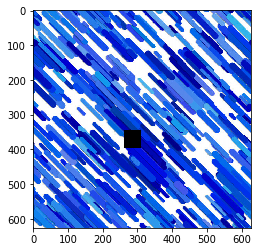

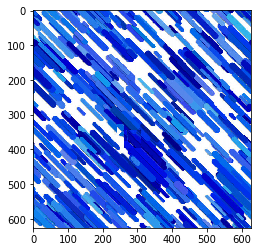

In [37]:
IMG_FILE = "imgs/rayures.jpg"

img = tools.read_img(IMG_FILE)
dropped_img = tools.remove_patch(370, 285, img, 25)[0]
tools.show(dropped_img)
reconstructed_img = reconstruction(dropped_img, ReconstructionSpiral)
tools.show(reconstructed_img)